# Predicting Review Helpfulness of Amazon Electronic Products
## Data Science Programming Spring 2020
## Darya Gahramanova

### Packages needed to run the code: numpy, pandas, matplotlib, scikit-learn, tensorflow, keras, nltk, gensim, tensorflow-hub
* pip install nltk / conda install -c anaconda nltk
* pip install gensim / conda install -c anaconda gensim
* pip install --upgrade tensorflow-hub / !pip install "tensorflow_hub>=0.6.0" / conda install -c anaconda tensorflow-hub

In [1]:
import numpy as np
import pandas as pd
import nltk
import string
import gensim
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Input
from keras.models import Model
import tensorflow_hub as hub
tf.random.set_seed(42)

Using TensorFlow backend.


# Getting the Data

### Reading data and skipping erroneous lines

In [2]:
data=pd.read_csv('amazon_reviews_us_Electronics_v1_00.tsv', sep='\t', error_bad_lines=False, warn_bad_lines=False)
data.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
1,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
3,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
4,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


In [3]:
data.shape

(3091024, 15)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3091024 entries, 0 to 3091023
Data columns (total 15 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   marketplace        object
 1   customer_id        int64 
 2   review_id          object
 3   product_id         object
 4   product_parent     int64 
 5   product_title      object
 6   product_category   object
 7   star_rating        int64 
 8   helpful_votes      int64 
 9   total_votes        int64 
 10  vine               object
 11  verified_purchase  object
 12  review_headline    object
 13  review_body        object
 14  review_date        object
dtypes: int64(5), object(10)
memory usage: 353.7+ MB


In [37]:
round(data['total_votes'].describe(),3)

count    3091024.000
mean           2.372
std           22.497
min            0.000
25%            0.000
50%            0.000
75%            1.000
max        12944.000
Name: total_votes, dtype: float64

Text(0, 0.5, 'Review Count')

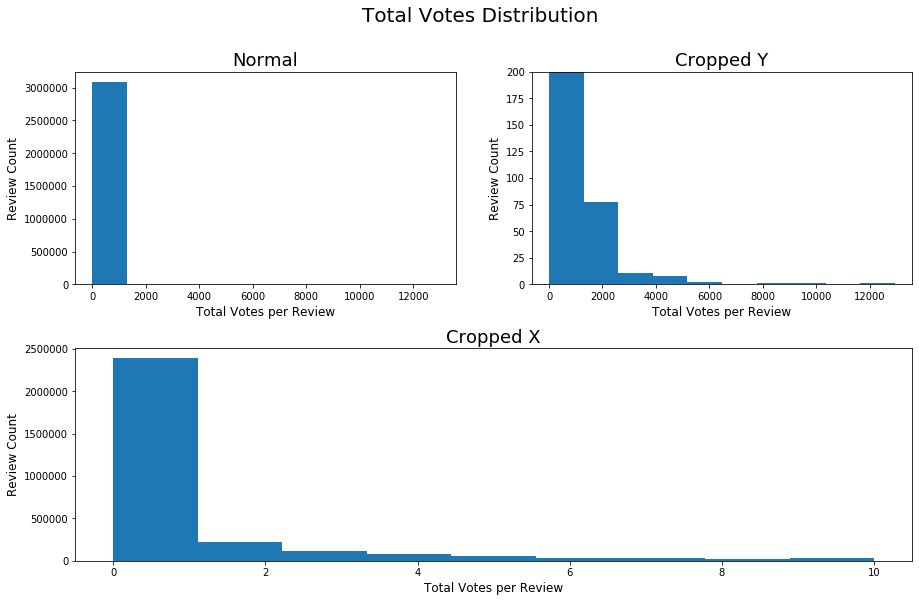

In [7]:
plt.figure(figsize=(15, 9))
plt.suptitle('Total Votes Distribution', fontsize=20)
plt.subplots_adjust(hspace=0.3)

plt.subplot(221)
plt.hist(data['total_votes'])
plt.title('Normal', fontsize=18)
plt.xlabel('Total Votes per Review', fontsize=12)
plt.ylabel('Review Count', fontsize=12)

plt.subplot(222)
plt.hist(data['total_votes'])
plt.ylim([0, 200])
plt.title('Cropped Y', fontsize=18)
plt.xlabel('Total Votes per Review', fontsize=12)
plt.ylabel('Review Count', fontsize=12)

bins = np.linspace(0, 10, 10)
plt.subplot(212)
plt.hist(data['total_votes'], bins)
plt.title('Cropped X', fontsize=18)
plt.xlabel('Total Votes per Review', fontsize=12)
plt.ylabel('Review Count', fontsize=12)

### Selecting reviews with 7 votes or more and from the US

In [8]:
new_data = data[data['marketplace'] == 'US']
new_data = new_data[new_data['total_votes'] >= 7]

print(len(data))
print(len(new_data))

3091024
203310


### Calculating review scores based on helpfulness (helpful votes out of total votes) and popularity (helpful votes per review among helpful votes per product) by using weighted average

In [9]:
total_helpful_votes = new_data.groupby(['product_id'],sort=False,as_index=False)['helpful_votes'].sum()
new_data = pd.merge(new_data,total_helpful_votes,on='product_id',how='left')
new_data.columns = new_data.columns.str.replace("helpful_votes_x","helpful_votes").str.replace("helpful_votes_y","total_helpful_votes")
new_data['helpfulness']=new_data['helpful_votes']/new_data['total_votes']
new_data['popularity']=new_data['helpful_votes']/new_data['total_helpful_votes']
new_data['score_continious'] = 0.7*new_data['helpfulness'] + 0.3*new_data['popularity']

### Converting scores to binary (0-unhelpful, 1-helpful) and dropping reviews with ambiguous scores (close to 0.5)

In [10]:
new_data['score_binary'] = pd.cut(new_data['score_continious'], bins=[0,0.3,0.7,1], labels=[0,2,1])
new_data.dropna(inplace=True)
new_data['score_binary'] = new_data['score_binary'].astype(int)
new_data = new_data[new_data['score_binary'] != 2]
new_data.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes,total_helpful_votes,helpfulness,popularity,score_continious,score_binary
count,9.468500e+04,9.468500e+04,94685.000000,94685.000000,94685.000000,94685.000000,94685.000000,94685.000000,94685.000000,94685.000000
mean,3.409019e+07,5.045238e+08,3.533844,27.118878,31.860664,524.388974,0.786669,0.323144,0.647612,0.770808
std,1.499615e+07,2.877404e+08,1.610900,112.317610,116.245660,2033.433978,0.320074,0.346000,0.279271,0.420315
min,1.019000e+04,3.034600e+04,1.000000,1.000000,7.000000,2.000000,0.004878,0.000023,0.005769,0.000000
25%,2.000568e+07,2.545690e+08,2.000000,7.000000,9.000000,28.000000,0.750000,0.024938,0.701287,1.000000
50%,3.639575e+07,5.029799e+08,4.000000,10.000000,13.000000,96.000000,0.956522,0.198925,0.731788,1.000000
75%,4.908556e+07,7.589189e+08,5.000000,19.000000,25.000000,356.000000,1.000000,0.500000,0.809091,1.000000
max,5.309658e+07,9.999911e+08,5.000000,12786.000000,12944.000000,43090.000000,1.000000,1.000000,1.000000,1.000000


### The least helpful reviews

In [11]:
for row in new_data[new_data['helpfulness']<0.01]['review_body']:
    print(row+'\n*********')

to expensive
*********
Don't buy their cancellation headphones until they reverse the cancellation of the movie.It is time to show that we are not defined by September 11th. If we are defined by a date it is July 4th.  It means we will not be defined by fear. We are defined by our beliefs, and we believe in free speech.  We intend to see The Interview in the theater. We in Washington intend to see it legally stoned and laugh our asses off.
*********
Why on earth would they charge so much for a headset with a cord? Any gamer knows that the issue with a gaming headset is running over the cord and damaging the connection, which renders the headset (that is expensive) completely useless.<br /><br />The reviews state that the sound is incredible. I have to agree, but thats not the issue.<br /><br />You would think that if they were putting so much R&D into this item, they would have gone the extra mile.
*********
you should never get head aches from watching TRUE 3D at all. its the converti

### The longest review

In [12]:
maxlen=-1
for doc in new_data["review_body"]:
    if maxlen<len(doc):
        maxlen=len(doc)
        maxdoc=doc
print(maxdoc,maxlen)

This review is for: CyberPower PR750LCD 525W UPS<br /><br />OVERVIEW:<br />-----------<br /><br />The home and small office UPS models we'll compare are:<br /><br />- APC: SMT750, SMT1000<br />- APC: SMC1000, SMC1500<br />- CyberPower: CP850PFCLCD, CP1000PFCLCD, CP1350PFCLCD<br />- CyberPower: PR750LCD, PR1000LCD, PR1500LCD<br /><br />These all:<br /><br />(A) KEEP ELECTRICITY GOING DURING A BLACKOUT and give a computer TIME TO SAFELY AUTO-SHUTDOWN.<br /><br />(B) Produce a PURE SINE WAVE to work with power supplies with Active PFC, like those on most Apple Macs, lots of newer windows PCs, etc.<br /><br />(C) Cost in the low hundreds, so we avoid server room type features like zero transfer time, external batteries, etc.<br /><br />We'll compare:<br />- How long things run during a blackout (RUNTIME)<br />- The WATTS they handle<br />- NOISE<br />- OUTLET COUNT and how many have battery power<br /><br />We'll also compare:<br />- AVR CAPABILITY including BOOST and TRIM (explained later

### Score vs. length of the reviews

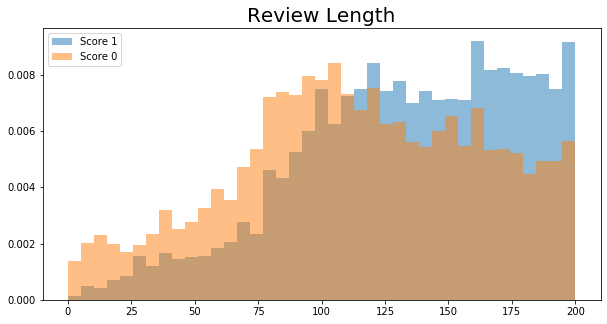

In [13]:
new_data['body_len'] = new_data.loc[:,'review_body'].apply(lambda x: len(str(x)) - str(x).count(" "))

bins = np.linspace(0, 200, 40)
plt.figure(figsize=(10, 5))
plt.hist(new_data[new_data['score_binary']==1]['body_len'], bins, alpha=0.5, normed=True, label='Score 1')
plt.hist(new_data[new_data['score_binary']==0]['body_len'], bins, alpha=0.5, normed=True, label='Score 0')
plt.legend(loc='upper left')
plt.title('Review Length', fontsize=20)
plt.show()

### Review score vs. star rating given by the reviewer

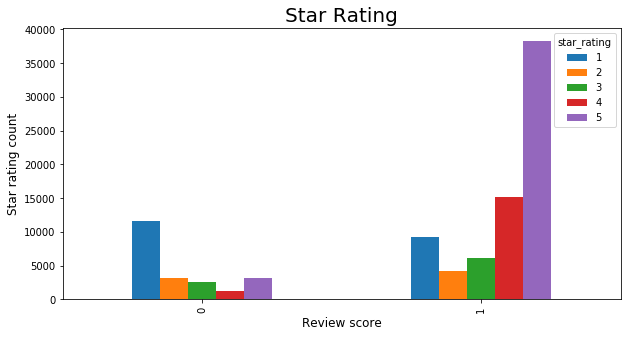

In [14]:
new_data.groupby('score_binary')['star_rating'].value_counts().unstack(level=1).plot.bar(figsize=(10,5))
plt.ylabel('Star rating count', fontsize=12)
plt.xlabel('Review score', fontsize=12)
plt.title('Star Rating', fontsize=20)
plt.show()

### Selecting a random subset of 15,000 reviews per each score

In [29]:
reviews = new_data[['review_body','score_binary']]

r1=reviews[reviews['score_binary']==0].sample(n=15000, random_state=8)
r2=reviews[reviews['score_binary']==1].sample(n=15000, random_state=8)
reviews = pd.concat([r1,r2], ignore_index=True,axis=0)

# Text Preprocessing

### Selecting stopwords

In [31]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [32]:
stop = ['am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 
        'doing', 'a', 'an', 'the', 'and', 'to', 'of', 'at', 'for', 'by', 's', 't', 'will', 'would', 'wo', 'd', 'll', 'm',
        'o', 're', 've', 'y', 'to', 'ai', '']

### Cleaning text

In [33]:
def clean_text(text):
    text = re.sub('<.*?>', ' ', text)
    text = re.sub('&#34;', ' ', text)
    text = re.sub("n't ", ' not ', text)
    text = re.sub("n' ", ' not' , text)
    text = re.sub(" ca ", ' can ', text)
    text = re.sub('\d+', ' 0 ', text)
    text = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', ' ', text)
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = " ".join([word for word in tokens if word not in stop])
    return text

In [34]:
review = reviews.review_body.iloc[0]
print(review)
print('*****')
review = clean_text(review)
print(review)

Havent purchased a set yet, but I read the reviews while trying to decide on whether or not to take a chance. Knowing you only get what you pay for these are my real world thoughts that i think will help others considering these speakers.<br /><br />1. Bass output has a direct relashoship to the wieght of the speaker. The speakers vibrates to make sound as the cone moves back and forth. A light speaker will move and vibrate in a way that takes energy away from the movement of the cone thus affecting bass output. The specs on these speakers say they are 55lbs, divide that by 5 speakers and no speaker will weight more than 15 or so pounds including the floor standing speakers. With that said this isnt a set up for loud bass heavy music.<br /><br />2. these are 6ohm speakers with means they have less resistance to an electrical input. One reviewer said you have to change your reciever to accomondate the 6ohm load. Most recievers dont have the capability to change the load on a set of spea

In [35]:
reviews['review_body'] = reviews['review_body'].apply(lambda x: clean_text(str(x)))

### Stemming cleaned text in a separate column

In [36]:
ps = nltk.PorterStemmer()

def stem_cleaned_text(text):
    tokens = text.split()
    text = " ".join([ps.stem(word) for word in tokens])
    return text

In [37]:
reviews['review_body_stemmed'] = reviews['review_body'].apply(lambda x: stem_cleaned_text(str(x)))

### Finding and merging important collocations in a separate column

In [39]:
split = reviews['review_body'].apply(lambda x: x.split())
unlist_reviews = [item for items in split for item in items]

blacklist = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 
             'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
             'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', '0']

from nltk.collocations import BigramCollocationFinder 
from nltk.metrics import BigramAssocMeasures 
bigram_measures = nltk.collocations.BigramAssocMeasures()

biagram_collocation = BigramCollocationFinder.from_words(unlist_reviews)
biagram_collocation.apply_word_filter(lambda w: w in blacklist)
colls = biagram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 300)
print(colls)

[('sound', 'quality'), ('asin', 'b'), ('better', 'than'), ('as', 'well'), ('customer', 'service'), ('there', 'no'), ('more', 'than'), ('battery', 'life'), ('can', 'not'), ('home', 'theater'), ('blu', 'ray'), ('set', 'up'), ('not', 'work'), ('less', 'than'), ('cd', 'player'), ('comes', 'with'), ('highly', 'recommend'), ('make', 'sure'), ('could', 'not'), ('so', 'far'), ('much', 'better'), ('very', 'good'), ('ear', 'buds'), ('happy', 'with'), ('high', 'end'), ('such', 'as'), ('alarm', 'clock'), ('even', 'though'), ('built', 'in'), ('build', 'quality'), ('remote', 'control'), ('noise', 'cancelling'), ('surge', 'protector'), ('living', 'room'), ('surround', 'sound'), ('based', 'on'), ('too', 'much'), ('stopped', 'working'), ('easy', 'use'), ('more', 'expensive'), ('dvd', 'player'), ('bottom', 'line'), ('come', 'with'), ('hard', 'drive'), ('ended', 'up'), ('very', 'happy'), ('usb', 'port'), ('figure', 'out'), ('not', 'know'), ('year', 'old'), ('rather', 'than'), ('pick', 'up'), ('years', 'a

In [40]:
def apply_collocations(text, colls):
    for c1, c2 in colls:
        text = text.replace("%s %s" % (c1, c2), "%s_%s" % (c1, c2))
    return text

reviews['review_body_collocations'] = reviews['review_body'].apply(lambda x: apply_collocations(x, colls))

In [116]:
print(reviews.review_body.iloc[4])
print('*****')
print(reviews.review_body_collocations.iloc[4])

ordered roku box linksys router bluerigger premium hdmi cable needed all 0 hook up work received roku box linksys router within 0 days not receive cable 0 days later could not use system wait i reccomend better shipping method because this not good
*****
ordered roku box linksys router bluerigger premium hdmi_cable needed all 0 hook_up work received roku box linksys router within 0 days not receive cable 0 days later could_not use system wait i reccomend better shipping method because this not good


# Train Test Split

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reviews[['review_body','review_body_stemmed','review_body_collocations']],
                                                    reviews['score_binary'], stratify=reviews['score_binary'], test_size=0.2)

In [47]:
print(X_train.shape)
print(X_test.shape)

(24000, 3)
(6000, 3)


# TF-IDF Vectorizer

### TF-IDF + SVD on Text

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

tfidf_vect = TfidfVectorizer(ngram_range=(1,1), max_features=10000)
tfidf_vect_fit = tfidf_vect.fit(X_train['review_body'])

tfidf_train = tfidf_vect_fit.transform(X_train['review_body'])
tfidf_test = tfidf_vect_fit.transform(X_test['review_body'])

svd = TruncatedSVD(n_components=100, n_iter=50).fit(tfidf_train)
svd_train = svd.transform(tfidf_train)
svd_test = svd.transform(tfidf_test)

### Bigram TF-IDF + SVD on Text

In [49]:
tfidf_vect = TfidfVectorizer(ngram_range=(2,2), max_features=10000)
tfidf_bigram_fit = tfidf_vect.fit(X_train['review_body'])

tfidf_bigram_train = tfidf_bigram_fit.transform(X_train['review_body'])
tfidf_bigram_test = tfidf_bigram_fit.transform(X_test['review_body'])

svd_bigram = TruncatedSVD(n_components=100, n_iter=50).fit(tfidf_bigram_train)
svd_bigram_train = svd_bigram.transform(tfidf_bigram_train)
svd_bigram_test = svd_bigram.transform(tfidf_bigram_test)

### TF-IDF + SVD on Stemmed Text

In [50]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,1), max_features=10000)
tfidf_stem_fit = tfidf_vect.fit(X_train['review_body_stemmed'])

tfidf_stem_train = tfidf_stem_fit.transform(X_train['review_body_stemmed'])
tfidf_stem_test = tfidf_stem_fit.transform(X_test['review_body_stemmed'])

svd_stem = TruncatedSVD(n_components=100, n_iter=50).fit(tfidf_stem_train)
svd_stem_train = svd_stem.transform(tfidf_stem_train)
svd_stem_test = svd_stem.transform(tfidf_stem_test)

### TF-IDF + SVD on Text with Collocations

In [51]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,1), max_features=10000)
tfidf_colls_fit = tfidf_vect.fit(X_train['review_body_collocations'])

tfidf_colls_train = tfidf_colls_fit.transform(X_train['review_body_collocations'])
tfidf_colls_test = tfidf_colls_fit.transform(X_test['review_body_collocations'])

svd_colls = TruncatedSVD(n_components=100, n_iter=50).fit(tfidf_colls_train)
svd_colls_train = svd_colls.transform(tfidf_colls_train)
svd_colls_test = svd_colls.transform(tfidf_colls_test)

## TF-IDF Evaluation

### Baseline Score (Random Forest)

In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def scores(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    fscore = f1_score(y_test, y_predict)
    print('\n', confusion_matrix(y_test,y_predict),
          '   Accuracy:', round(accuracy, 3),
          ' /   Precision:', round(precision, 3),
          ' /   Recall:', round(recall, 3),
          ' /   F1:', round(fscore, 3))

In [53]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=16)

y_test_shuffle = y_test.sample(frac=1).reset_index(drop=True)

rf_model = rf.fit(svd_train, y_train)
y_pred_baseline = rf_model.predict(svd_test)

scores(y_test_shuffle, y_pred_baseline)


 [[1500 1500]
 [1547 1453]]    Accuracy: 0.492  /   Precision: 0.492  /   Recall: 0.484  /   F1: 0.488


### TF-IDF + SVD on Text (Random Forest)

In [54]:
rf = RandomForestClassifier(n_jobs=-1, random_state=16)

rf_model = rf.fit(svd_train, y_train)
y_pred_rf = rf_model.predict(svd_test)

scores(y_test, y_pred_rf)


 [[2282  718]
 [ 765 2235]]    Accuracy: 0.753  /   Precision: 0.757  /   Recall: 0.745  /   F1: 0.751


### Bigram TF-IDF + SVD on Text (Random Forest)

In [55]:
rf_model = rf.fit(svd_bigram_train, y_train)
y_pred_rf = rf_model.predict(svd_bigram_test)

scores(y_test, y_pred_rf)


 [[2193  807]
 [ 892 2108]]    Accuracy: 0.717  /   Precision: 0.723  /   Recall: 0.703  /   F1: 0.713


### TF-IDF + SVD on Text with Collocations (Random Forest)

In [57]:
rf_model = rf.fit(svd_colls_train, y_train)
y_pred_rf = rf_model.predict(svd_colls_test)

scores(y_test, y_pred_rf)


 [[2283  717]
 [ 742 2258]]    Accuracy: 0.757  /   Precision: 0.759  /   Recall: 0.753  /   F1: 0.756


### TF-IDF + SVD on Stemmed Text (Random Forest)

In [56]:
rf_model = rf.fit(svd_stem_train, y_train)
y_pred_rf = rf_model.predict(svd_stem_test)

scores(y_test, y_pred_rf)


 [[2266  734]
 [ 722 2278]]    Accuracy: 0.757  /   Precision: 0.756  /   Recall: 0.759  /   F1: 0.758


### TF-IDF + SVD on Stemmed Text (Fine-Tuned Random Forest)

In [58]:
rf = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=5, min_samples_leaf=5, n_jobs=-1, random_state=16)

rf_model = rf.fit(svd_stem_train, y_train)
y_pred_rf = rf_model.predict(svd_stem_test)

scores(y_test, y_pred_rf)


 [[2266  734]
 [ 660 2340]]    Accuracy: 0.768  /   Precision: 0.761  /   Recall: 0.78  /   F1: 0.77


### TF-IDF + SVD on Stemmed Text (Gradient Boosting Classifier)

In [59]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=16)

gb_model = gb.fit(svd_stem_train, y_train)
y_pred_gb = gb_model.predict(svd_stem_test)

scores(y_test, y_pred_gb)


 [[2260  740]
 [ 691 2309]]    Accuracy: 0.762  /   Precision: 0.757  /   Recall: 0.77  /   F1: 0.763


### TF-IDF + SVD on Stemmed Text (Dense Neural Network)

In [60]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tfidf_stem_dnn_model = keras.models.Sequential([
    keras.layers.Dense(300, activation="relu", input_dim=100),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation="sigmoid")
])
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.8, nesterov=True)
tfidf_stem_dnn_model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
tfidf_stem_dnn_model.fit(svd_stem_train, y_train, validation_split=0.3, epochs=100, callbacks=[early_stopping_cb])
y_predict = tfidf_stem_dnn_model.predict_classes(svd_stem_test)
scores(y_test, y_predict)

Train on 16800 samples, validate on 7200 samples
Epoch 1/100
16800/16800 [==============================] - 2s 124us/sample - loss: 0.6786 - accuracy: 0.6130 - val_loss: 0.6562 - val_accuracy: 0.6578
Epoch 2/100
16800/16800 [==============================] - 2s 110us/sample - loss: 0.6126 - accuracy: 0.6982 - val_loss: 0.5574 - val_accuracy: 0.7318
Epoch 3/100
16800/16800 [==============================] - 2s 92us/sample - loss: 0.5387 - accuracy: 0.7329 - val_loss: 0.5105 - val_accuracy: 0.7556
Epoch 4/100
16800/16800 [==============================] - 2s 92us/sample - loss: 0.5147 - accuracy: 0.7529 - val_loss: 0.5050 - val_accuracy: 0.7558
Epoch 5/100
16800/16800 [==============================] - 1s 87us/sample - loss: 0.5036 - accuracy: 0.7555 - val_loss: 0.4998 - val_accuracy: 0.7628
Epoch 6/100
16800/16800 [==============================] - 1s 84us/sample - loss: 0.5010 - accuracy: 0.7583 - val_loss: 0.4930 - val_accuracy: 0.7658
Epoch 7/100
16800/16800 [========================

### TF-IDF + SVD on Stemmed Text (Recurrent Neural Network)

In [61]:
svd_stem_train_3d = np.reshape(svd_stem_train, (svd_stem_train.shape[0], 1, svd_stem_train.shape[1]))
svd_stem_test_3d = np.reshape(svd_stem_test, (svd_stem_test.shape[0], 1, svd_stem_test.shape[1]))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
tfidf_stem_rnn_model = keras.models.Sequential([
    keras.layers.GRU(100, dropout=0.2, input_shape=[1, 100], return_sequences=True),
    keras.layers.GRU(100, dropout=0.2),
    keras.layers.Dense(1, activation="sigmoid")
])
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
tfidf_stem_rnn_model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
tfidf_stem_rnn_model.fit(svd_stem_train_3d, y_train, validation_split=0.3, epochs=100, callbacks=[early_stopping_cb])
y_predict = tfidf_stem_rnn_model.predict_classes(svd_stem_test_3d)
scores(y_test, y_predict)

Train on 16800 samples, validate on 7200 samples
Epoch 1/100
16800/16800 [==============================] - 5s 291us/sample - loss: 0.6909 - accuracy: 0.5451 - val_loss: 0.6881 - val_accuracy: 0.5828
Epoch 2/100
16800/16800 [==============================] - 3s 163us/sample - loss: 0.6833 - accuracy: 0.5946 - val_loss: 0.6763 - val_accuracy: 0.6453
Epoch 3/100
16800/16800 [==============================] - 3s 155us/sample - loss: 0.6650 - accuracy: 0.6307 - val_loss: 0.6430 - val_accuracy: 0.6940
Epoch 4/100
16800/16800 [==============================] - 3s 159us/sample - loss: 0.6306 - accuracy: 0.6583 - val_loss: 0.5888 - val_accuracy: 0.7324
Epoch 5/100
16800/16800 [==============================] - 3s 163us/sample - loss: 0.5889 - accuracy: 0.6948 - val_loss: 0.5478 - val_accuracy: 0.7443
Epoch 6/100
16800/16800 [==============================] - 3s 171us/sample - loss: 0.5681 - accuracy: 0.7068 - val_loss: 0.5345 - val_accuracy: 0.7510
Epoch 7/100
16800/16800 [====================

### Full TF-IDF on Stemmed Text (Recurrent Neural Network)

In [62]:
tfidf_stem_train = tfidf_stem_train.toarray()
tfidf_stem_test = tfidf_stem_test.toarray()
tfidf_stem_train_3d = np.reshape(tfidf_stem_train, (tfidf_stem_train.shape[0], 1, tfidf_stem_train.shape[1]))
tfidf_stem_test_3d = np.reshape(tfidf_stem_test, (tfidf_stem_test.shape[0], 1, tfidf_stem_test.shape[1]))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tfidf_full_stem_rnn_model = keras.models.Sequential([
    keras.layers.GRU(50, dropout=0.2, input_shape=[1, 10000], return_sequences=True),
    keras.layers.GRU(50, dropout=0.2),
    keras.layers.Dense(1, activation="sigmoid")
])
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.8, nesterov=True)
tfidf_full_stem_rnn_model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
tfidf_full_stem_rnn_model.fit(tfidf_stem_train_3d, y_train, validation_split=0.3, epochs=100, callbacks=[early_stopping_cb])
y_predict = tfidf_full_stem_rnn_model.predict_classes(tfidf_stem_test_3d)
scores(y_test, y_predict)

Train on 16800 samples, validate on 7200 samples
Epoch 1/100
16800/16800 [==============================] - 27s 2ms/sample - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6931 - val_accuracy: 0.4983
Epoch 2/100
16800/16800 [==============================] - 15s 919us/sample - loss: 0.6927 - accuracy: 0.5105 - val_loss: 0.6923 - val_accuracy: 0.5471
Epoch 3/100
16800/16800 [==============================] - 15s 907us/sample - loss: 0.6922 - accuracy: 0.5263 - val_loss: 0.6918 - val_accuracy: 0.4983
Epoch 4/100
16800/16800 [==============================] - 14s 847us/sample - loss: 0.6915 - accuracy: 0.5508 - val_loss: 0.6909 - val_accuracy: 0.5017
Epoch 5/100
16800/16800 [==============================] - 14s 828us/sample - loss: 0.6902 - accuracy: 0.5680 - val_loss: 0.6892 - val_accuracy: 0.5567
Epoch 6/100
16800/16800 [==============================] - 14s 837us/sample - loss: 0.6882 - accuracy: 0.5939 - val_loss: 0.6867 - val_accuracy: 0.5715
Epoch 7/100
16800/16800 [================

# Doc2Vec Embedding

### Vectorize inputs by training a Doc2vec model on the train set

In [71]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

X_train_corpus = X_train['review_body'].apply(lambda x: x.split()).reset_index(drop=True)
X_test_corpus = X_test['review_body'].apply(lambda x: x.split()).reset_index(drop=True)

vector_size = 100
tagged_train = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train_corpus)]
tagged_test = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_test_corpus)]
model = Doc2Vec(vector_size=vector_size, window=2, min_count=1, workers=4)
model.build_vocab(tagged_train)
model.train(tagged_train, total_examples=model.corpus_count, epochs=model.iter)

X_train_dv = np.array([model.docvecs[i] for i in range(len(X_train_corpus))])
X_test_dv = np.array([model.infer_vector(X_test_corpus[i]) for i in range(len(X_test_corpus))])
doc2vec_X_train = pd.DataFrame(X_train_dv).set_index(X_train.index)
doc2vec_X_test = pd.DataFrame(X_test_dv).set_index(X_test.index)

### Doc2Vec on Text (Random Forest)

In [72]:
rf_model = rf.fit(doc2vec_X_train, y_train)
y_pred_rf = rf_model.predict(doc2vec_X_test)

scores(y_test, y_pred_rf)


 [[1781 1219]
 [ 446 2554]]    Accuracy: 0.722  /   Precision: 0.677  /   Recall: 0.851  /   F1: 0.754


### Doc2Vec on Text (Dense Neural Network)

In [73]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
d2v_dnn_model = keras.models.Sequential([
    keras.layers.Dense(200, activation="relu", input_dim=vector_size),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(100, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation="sigmoid")
])
sgd = keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True)
d2v_dnn_model.compile(loss="binary_crossentropy", optimizer='sgd', metrics=["accuracy"])
d2v_dnn_model.fit(doc2vec_X_train, y_train, validation_split=0.3, epochs=100, callbacks=[early_stopping_cb])
y_predict = d2v_dnn_model.predict_classes(doc2vec_X_test)
scores(y_test, y_predict)

Train on 16800 samples, validate on 7200 samples
Epoch 1/100
16800/16800 [==============================] - 2s 109us/sample - loss: 1.8954 - accuracy: 0.5785 - val_loss: 1.7574 - val_accuracy: 0.6722
Epoch 2/100
16800/16800 [==============================] - 1s 81us/sample - loss: 1.6377 - accuracy: 0.6651 - val_loss: 1.5256 - val_accuracy: 0.6714
Epoch 3/100
16800/16800 [==============================] - 1s 81us/sample - loss: 1.4278 - accuracy: 0.6806 - val_loss: 1.3373 - val_accuracy: 0.6806
Epoch 4/100
16800/16800 [==============================] - 1s 83us/sample - loss: 1.2600 - accuracy: 0.6858 - val_loss: 1.1881 - val_accuracy: 0.6846
Epoch 5/100
16800/16800 [==============================] - 1s 82us/sample - loss: 1.1246 - accuracy: 0.6955 - val_loss: 1.0689 - val_accuracy: 0.6901
Epoch 6/100
16800/16800 [==============================] - 1s 82us/sample - loss: 1.0178 - accuracy: 0.6981 - val_loss: 0.9739 - val_accuracy: 0.6933
Epoch 7/100
16800/16800 [=========================

Epoch 55/100
16800/16800 [==============================] - 1s 83us/sample - loss: 0.5302 - accuracy: 0.7450 - val_loss: 0.5393 - val_accuracy: 0.7318
Epoch 56/100
16800/16800 [==============================] - 1s 83us/sample - loss: 0.5299 - accuracy: 0.7443 - val_loss: 0.5389 - val_accuracy: 0.7318
Epoch 57/100
16800/16800 [==============================] - 1s 81us/sample - loss: 0.5314 - accuracy: 0.7429 - val_loss: 0.5389 - val_accuracy: 0.7312
Epoch 58/100
16800/16800 [==============================] - 1s 80us/sample - loss: 0.5296 - accuracy: 0.7456 - val_loss: 0.5413 - val_accuracy: 0.7289
Epoch 59/100
16800/16800 [==============================] - 1s 81us/sample - loss: 0.5293 - accuracy: 0.7436 - val_loss: 0.5401 - val_accuracy: 0.7282
Epoch 60/100
16800/16800 [==============================] - 1s 79us/sample - loss: 0.5290 - accuracy: 0.7449 - val_loss: 0.5404 - val_accuracy: 0.7285
Epoch 61/100
16800/16800 [==============================] - 1s 81us/sample - loss: 0.5290 - ac

In [62]:
tfidf_stem_train = tfidf_stem_train.toarray()
tfidf_stem_test = tfidf_stem_test.toarray()
tfidf_stem_train_3d = np.reshape(tfidf_stem_train, (tfidf_stem_train.shape[0], 1, tfidf_stem_train.shape[1]))
tfidf_stem_test_3d = np.reshape(tfidf_stem_test, (tfidf_stem_test.shape[0], 1, tfidf_stem_test.shape[1]))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tfidf_full_stem_rnn_model = keras.models.Sequential([
    keras.layers.GRU(50, dropout=0.2, input_shape=[1, 10000], return_sequences=True),
    keras.layers.GRU(50, dropout=0.2),
    keras.layers.Dense(1, activation="sigmoid")
])
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.8, nesterov=True)
tfidf_full_stem_rnn_model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
tfidf_full_stem_rnn_model.fit(tfidf_stem_train_3d, y_train, validation_split=0.3, epochs=100, callbacks=[early_stopping_cb])
y_predict = tfidf_full_stem_rnn_model.predict_classes(tfidf_stem_test_3d)
scores(y_test, y_predict)

Train on 16800 samples, validate on 7200 samples
Epoch 1/100
16800/16800 [==============================] - 27s 2ms/sample - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6931 - val_accuracy: 0.4983
Epoch 2/100
16800/16800 [==============================] - 15s 919us/sample - loss: 0.6927 - accuracy: 0.5105 - val_loss: 0.6923 - val_accuracy: 0.5471
Epoch 3/100
16800/16800 [==============================] - 15s 907us/sample - loss: 0.6922 - accuracy: 0.5263 - val_loss: 0.6918 - val_accuracy: 0.4983
Epoch 4/100
16800/16800 [==============================] - 14s 847us/sample - loss: 0.6915 - accuracy: 0.5508 - val_loss: 0.6909 - val_accuracy: 0.5017
Epoch 5/100
16800/16800 [==============================] - 14s 828us/sample - loss: 0.6902 - accuracy: 0.5680 - val_loss: 0.6892 - val_accuracy: 0.5567
Epoch 6/100
16800/16800 [==============================] - 14s 837us/sample - loss: 0.6882 - accuracy: 0.5939 - val_loss: 0.6867 - val_accuracy: 0.5715
Epoch 7/100
16800/16800 [================

# Training with an Embedding Layer

In [77]:
tokenizer = Tokenizer(num_words=5000, oov_token='OOV', filters='\t\n', lower=False)
tokenizer.fit_on_texts(list(X_train['review_body'].values))
encoded_train_list = tokenizer.texts_to_sequences(list(X_train['review_body'].values))
encoded_test_list = tokenizer.texts_to_sequences(list(X_test['review_body'].values))

In [81]:
print(X_train.review_body.iloc[0])
print('\n',tokenizer.sequences_to_texts([encoded_train_list[0]]))

i bought two these 0 speakers after viewing all videos ratings see twit reviews i found that most respondents terribly wrong these items performed well above any expectations great clarity base no problems all maybe rattle from other review from his laying speaker on sub my friends all jawbones bose we active comparison hands down they said braven them in when i paired two stereo separation jaws dropped soooooo loud full recommended

 ['i bought two these 0 speakers after viewing all videos ratings see OOV reviews i found that most OOV terribly wrong these items performed well above any expectations great clarity base no problems all maybe rattle from other review from his laying speaker on sub my friends all OOV bose we active comparison hands down they said OOV them in when i paired two stereo separation OOV dropped OOV loud full recommended']


In [82]:
tokenizer.word_index.items()

dict_items([('OOV', 1), ('i', 2), ('0', 3), ('it', 4), ('not', 5), ('this', 6), ('that', 7), ('you', 8), ('in', 9), ('with', 10), ('my', 11), ('on', 12), ('but', 13), ('as', 14), ('they', 15), ('sound', 16), ('so', 17), ('if', 18), ('or', 19), ('can', 20), ('one', 21), ('all', 22), ('from', 23), ('these', 24), ('very', 25), ('your', 26), ('out', 27), ('up', 28), ('just', 29), ('when', 30), ('like', 31), ('good', 32), ('no', 33), ('them', 34), ('use', 35), ('me', 36), ('more', 37), ('get', 38), ('there', 39), ('about', 40), ('only', 41), ('great', 42), ('quality', 43), ('than', 44), ('which', 45), ('other', 46), ('what', 47), ('player', 48), ('headphones', 49), ('also', 50), ('music', 51), ('well', 52), ('product', 53), ('some', 54), ('even', 55), ('time', 56), ('speakers', 57), ('after', 58), ('better', 59), ('really', 60), ('because', 61), ('much', 62), ('ipod', 63), ('any', 64), ('unit', 65), ('work', 66), ('could', 67), ('radio', 68), ('off', 69), ('price', 70), ('speaker', 71), ('c

In [83]:
maxlen=-1
for doc in encoded_train_list:
    if maxlen<len(doc):
        maxlen=len(doc)
for doc in encoded_test_list:
    if maxlen<len(doc):
        maxlen=len(doc)
maxlen

4701

In [84]:
padded_train = pad_sequences(encoded_train_list,maxlen=maxlen,padding='post',value=0)
padded_test = pad_sequences(encoded_test_list,maxlen=maxlen,padding='post',value=0)

In [94]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
embed_size = 30
embed_dnn_model = keras.models.Sequential([
    keras.layers.Embedding(5001, embed_size, mask_zero=True, input_shape=(maxlen,)),
    keras.layers.Flatten(),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation="sigmoid")
])
adam=keras.optimizers.Adam(learning_rate=0.01)
embed_dnn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
embed_dnn_history = embed_dnn_model.fit(padded_train, y_train, validation_split=0.3, epochs=30, callbacks=[early_stopping_cb])
y_predict = embed_dnn_model.predict_classes(padded_test)
scores(y_test, y_predict)

Train on 16800 samples, validate on 7200 samples
Epoch 1/30
16800/16800 [==============================] - 110s 7ms/sample - loss: 0.6506 - accuracy: 0.6463 - val_loss: 0.5053 - val_accuracy: 0.7699
Epoch 2/30
16800/16800 [==============================] - 130s 8ms/sample - loss: 0.4720 - accuracy: 0.7865 - val_loss: 0.4619 - val_accuracy: 0.7903
Epoch 3/30
16800/16800 [==============================] - 119s 7ms/sample - loss: 0.3934 - accuracy: 0.8340 - val_loss: 0.4720 - val_accuracy: 0.7828
Epoch 4/30
16800/16800 [==============================] - 124s 7ms/sample - loss: 0.3318 - accuracy: 0.8631 - val_loss: 0.4957 - val_accuracy: 0.7875
Epoch 5/30
16800/16800 [==============================] - 119s 7ms/sample - loss: 0.2693 - accuracy: 0.8955 - val_loss: 0.5440 - val_accuracy: 0.7815
Epoch 6/30
16800/16800 [==============================] - 121s 7ms/sample - loss: 0.1855 - accuracy: 0.9325 - val_loss: 0.6910 - val_accuracy: 0.7733
Epoch 7/30
16800/16800 [===========================

In [87]:
embed_dnn_model.layers[0].get_weights()[0]

array([[-0.00380842, -0.00501538, -0.00343404, ...,  0.0036818 ,
        -0.00577665, -0.00438369],
       [ 0.05084489, -0.03569658, -0.00452823, ...,  0.01957787,
         0.0150547 , -0.0413129 ],
       [-0.04526151, -0.04305775,  0.03677972, ...,  0.0115817 ,
         0.05535166,  0.00146729],
       ...,
       [-0.01580401, -0.03636425,  0.02508305, ...,  0.0152963 ,
         0.0560443 , -0.00471302],
       [ 0.03952652, -0.05761565,  0.04142889, ..., -0.07290635,
         0.06285477,  0.02309928],
       [-0.00025334, -0.04320831, -0.01117168, ...,  0.00591105,
        -0.04468035,  0.0170653 ]], dtype=float32)

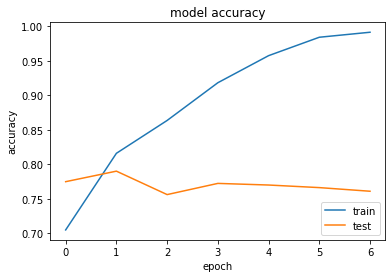

In [88]:
plt.plot(embed_dnn_history.history['accuracy'])
plt.plot(embed_dnn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

# Using a Pretrained Embedding Layer

### 50-Dimentional Layer

In [49]:
dim50_model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
dim50_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
dim50_model.fit(X_train['review_body'], y_train, validation_split=0.3, epochs=10)
y_predict = dim50_model.predict_classes(X_test['review_body'])
scores(y_test, y_predict)

Train on 16799 samples, validate on 7200 samples
Epoch 1/10
16799/16799 [==============================] - 105s 6ms/sample - loss: 0.5838 - accuracy: 0.6907 - val_loss: 0.5495 - val_accuracy: 0.7246
Epoch 2/10
16799/16799 [==============================] - 106s 6ms/sample - loss: 0.5396 - accuracy: 0.7324 - val_loss: 0.5392 - val_accuracy: 0.7312
Epoch 3/10
16799/16799 [==============================] - 101s 6ms/sample - loss: 0.5342 - accuracy: 0.7342 - val_loss: 0.5307 - val_accuracy: 0.7357
Epoch 4/10
16799/16799 [==============================] - 104s 6ms/sample - loss: 0.5313 - accuracy: 0.7371 - val_loss: 0.5274 - val_accuracy: 0.7393
Epoch 5/10
16799/16799 [==============================] - 103s 6ms/sample - loss: 0.5302 - accuracy: 0.7371 - val_loss: 0.5271 - val_accuracy: 0.7400
Epoch 6/10
16799/16799 [==============================] - 107s 6ms/sample - loss: 0.5271 - accuracy: 0.7400 - val_loss: 0.5251 - val_accuracy: 0.7428
Epoch 7/10
16799/16799 [===========================

### 128-Dimentional Layer

In [50]:
dim128_model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", output_shape=[128],
                   input_shape=[], dtype=tf.string),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
dim128_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

dim128_model.fit(X_train['review_body'], y_train, validation_split=0.3, epochs=10)
y_predict = dim128_model.predict_classes(X_test['review_body'])
scores(y_test, y_predict)

Train on 16799 samples, validate on 7200 samples
Epoch 1/10
16799/16799 [==============================] - 249s 15ms/sample - loss: 0.5543 - accuracy: 0.7182 - val_loss: 0.5130 - val_accuracy: 0.7503
Epoch 2/10
16799/16799 [==============================] - 248s 15ms/sample - loss: 0.5065 - accuracy: 0.7589 - val_loss: 0.4928 - val_accuracy: 0.7704
Epoch 3/10
16799/16799 [==============================] - 248s 15ms/sample - loss: 0.4971 - accuracy: 0.7647 - val_loss: 0.4849 - val_accuracy: 0.7781
Epoch 4/10
16799/16799 [==============================] - 248s 15ms/sample - loss: 0.4903 - accuracy: 0.7683 - val_loss: 0.4801 - val_accuracy: 0.7792
Epoch 5/10
16799/16799 [==============================] - 248s 15ms/sample - loss: 0.4870 - accuracy: 0.7706 - val_loss: 0.4799 - val_accuracy: 0.7724
Epoch 6/10
16799/16799 [==============================] - 248s 15ms/sample - loss: 0.4793 - accuracy: 0.7742 - val_loss: 0.4754 - val_accuracy: 0.7772
Epoch 7/10
16799/16799 [=====================

# Making Predictions

In [109]:
print(X_test.review_body.iloc[0])
test = padded_test[0].reshape(1,-1)
print('\nPredicted probability:', embed_dnn_model.predict(test))
print('\nPredicted class:', embed_dnn_model.predict_classes(test))

i used it on one cd which i thought it could fix i wrong all it doom it life indoor frisbee luckily there trash can nearby

Predicted probability: [[0.1904429]]

Predicted class: [[0]]


In [110]:
print(X_test.review_body.iloc[1])
test = padded_test[1].reshape(1,-1)
print('\nPredicted probability:', embed_dnn_model.predict(test))
print('\nPredicted class:', embed_dnn_model.predict_classes(test))

these easily most powerful headphones i ever owned frequency range absolutely stellar admittedly my car stereo nothing special but it not pick up nearly range sound these headphones i hear things down on low end that my car can not even dream picking up i previous response mentioned that these djs only i disagree they anyone that loves good sounding music i say though price they can affordably launch anyone into dj quality headphone arena

Predicted probability: [[0.5810358]]

Predicted class: [[1]]


# Code References

Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition - Geron, Aurelien

https://www.linkedin.com/learning/nlp-with-python-for-machine-learning-essential-training

https://medium.com/@morga046/multi-class-text-classification-with-doc2vec-and-t-sne-a-full-tutorial-55eb24fc40d3

https://towardsdatascience.com/collocations-in-nlp-using-nltk-library-2541002998db
